# ## MODELISATION / PREDICTION SENTIMENT "SUPPLIER REPLIES" 

### Required packages

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report



### Import review data of La Redoute

In [5]:
file = "redoute_v31.csv"
df = pd.read_csv(file, sep =",", index_col = 0)

## MODELISATION NAIVE / APPROCHE TEXT MINING

In [6]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report

# Téléchargement des packages nécessaires de NLTK

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Initialiser le stemmer
stemmer = SnowballStemmer("french")

# Exemple de commentaire
# comment = """
# Bonjour, merci d'avoir pris le temps de nous partager votre avis. La Redoute ayant à cœur de répondre au mieux aux attentes de ses clients, nous ferons remonter votre commentaire afin d'améliorer nos services. Nous nous excusons de nouveau pour ce désagrément. Ilham de l'équipe Service Client.
# """

def preprocess_text(text):
    # Convertir en minuscules
    text = text.lower()
    # Supprimer les URL
    text = re.sub(r'http\S+', '', text)
    # Supprimer les noms et les salutations (Exemple basique)
    text = re.sub(r'bonjour,','', text)
    text = re.sub(r'[\w\.-]+ de l\'équipe service client', '', text)
    # Supprimer la ponctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Supprimer les chiffres
    text = re.sub(r'\d+', '', text)
    # Tokenisation
    tokens = nltk.word_tokenize(text)
    # Suppression des stop words
    tokens = [word for word in tokens if word not in stopwords.words('french')]
    # Lemmatization
    tokens = [stemmer.stem(word) for word in tokens]
    return ' '.join(tokens)

# Appliquer le pretraitement sur la colonne des commentaires
# preprocessed_comment = preprocess_text(comment)
# print(preprocessed_comment)

df['processed_comments']= df['SupplierReply'].apply(preprocess_text)


# Vectorisation
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['processed_comments'])

# Séparation des données
y = df['rating'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Choix et entraînement du modèle
model = LogisticRegression(max_iter=1000)  # max_iter peut être augmenté si la convergence n'est pas atteinte
model.fit(X_train, y_train)

# Évaluation du modèle
y_pred = model.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(confusion_matrix(y_test, y_pred))


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Mike\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mike\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Mike\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Accuracy: 0.5456110154905336
[[ 19  14 160   6   0]
 [ 18   5 149  10   0]
 [ 20   8 255  35   0]
 [  3   1  73 355   0]
 [  0   2   6  23   0]]


## MODELISATION/APPROCHE TEXT MINING VADER MODEL

In [7]:
# STEP 1 . VADER SENTIMENT SCORING

In [ ]:
# Nous allons utiliser le  "SentimentIntensityAnalyzer" de NLTK    pour obtenir les "neg/neu/pos scores"  du texte

# On utilise l'approche du  "bag of words" approach:
# 1.Les Stop words sont retires
# 2. Chaque mot est "scoré" et  ensuite combiné avec le score total. 

In [8]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
import nltk
nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Mike\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [9]:
sia = SentimentIntensityAnalyzer()

In [10]:
sia.polarity_scores('I am so happy!')

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [11]:
sia.polarity_scores('I feel so bad')

{'neg': 0.655, 'neu': 0.345, 'pos': 0.0, 'compound': -0.5849}

In [12]:
example = '''In the dim twilight of progress, city skylines loom, stark 
and unfeeling against a backdrop of often too-grey skies. The streets, 
bustling yet impersonal, echo with the hurried steps of souls brushing
past each other, connected by proximity yet isolated in spirit. 
The air, tinged with the bite of pollution, stings the eyes and 
constricts breaths. Parks, once vibrant green retreats, fade 
into the drabness of routine under the unyielding city din. 
And at night, even the stars seem to shy away, leaving the world 
below to languish in the half-hearted glow of streetlamps and 
a silence that’s never quite complete'''

In [13]:
sia.polarity_scores(example)

{'neg': 0.078, 'neu': 0.849, 'pos': 0.073, 'compound': 0.1027}

In [16]:
df = df.reset_index()

In [17]:
# run the polarity score on the entire dataset
res = {}
for i,row in tqdm(df.iterrows(), total=len(df)):
    text = row['SupplierReply']
    myid = row['id']
    res[myid] = sia.polarity_scores(text)
    

  0%|          | 0/5806 [00:00<?, ?it/s]

In [18]:
res

{'rev-0134d691-cf06-4caa-8d42-528cea655fa2': {'neg': 0.0,
  'neu': 0.9,
  'pos': 0.1,
  'compound': 0.5696},
 'rev-97bff9c6-1d08-4caf-8c8a-5fc8f168d817': {'neg': 0.0,
  'neu': 1.0,
  'pos': 0.0,
  'compound': 0.0},
 'rev-b9f9a2c6-9c55-48d4-980a-3224367b0fc8': {'neg': 0.0,
  'neu': 1.0,
  'pos': 0.0,
  'compound': 0.0},
 'rev-31ced4d5-10da-49dc-9111-8eb9ee5f2fe4': {'neg': 0.0,
  'neu': 1.0,
  'pos': 0.0,
  'compound': 0.0},
 'rev-d1d74f83-bd9a-468f-beeb-b2c64ebc65b2': {'neg': 0.0,
  'neu': 1.0,
  'pos': 0.0,
  'compound': 0.0},
 'rev-e3e0c70f-ba7d-4ab1-856c-fab521200c1b': {'neg': 0.0,
  'neu': 0.9,
  'pos': 0.1,
  'compound': 0.5696},
 'rev-3d66e3f3-e22c-4e3c-a236-12e97f9b3dfe': {'neg': 0.0,
  'neu': 1.0,
  'pos': 0.0,
  'compound': 0.0},
 'rev-79de8ba5-6963-4095-bbcf-655e22e6ed67': {'neg': 0.0,
  'neu': 1.0,
  'pos': 0.0,
  'compound': 0.0},
 'rev-217b0185-fcf2-4ef8-8851-7a049f77f164': {'neg': 0.0,
  'neu': 1.0,
  'pos': 0.0,
  'compound': 0.0},
 'rev-711159db-8cf0-445d-b959-17aa34f5da

In [19]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index':'id'})
vaders = vaders.merge(df, how='left')

In [20]:
# Now we have sentiment score and metadata
vaders.head()

,id,neg,neu,pos,compound,rating,comment,createdAt,SupplierReply,SupplierReplyDate,processed_comments
0,rev-0134d691-cf06-4caa-8d42-528cea655fa2,0.0,0.9,0.1,0.5696,4,"Une livraison assez rapide, les tailles sont b...",2023-10-06 18:09:56,"Bonjour, merci pour vos encouragements. Vos re...",2023-10-13 09:56:10,merc encourag remarqu partag pris compt léquip...
1,rev-97bff9c6-1d08-4caf-8c8a-5fc8f168d817,0.0,1.0,0.0,0.0000,4,Juste vous dire que la qualité est inférieure ...,2023-10-05 14:37:16,"Bonjour, merci d'avoir pris le temps de nous p...",2023-10-12 10:01:19,merc davoir pris temp partag avis redout cœur ...
2,rev-b9f9a2c6-9c55-48d4-980a-3224367b0fc8,0.0,1.0,0.0,0.0000,4,Vendeur et vendeuse au top dans le magasin Gal...,2023-10-04 14:38:55,"Bonjour, merci de nous partager votre expérien...",2023-10-11 12:42:01,merc partag expérient rav lorsqu voyon avis po...
3,rev-31ced4d5-10da-49dc-9111-8eb9ee5f2fe4,0.0,1.0,0.0,0.0000,4,M'ayant été signalé que mon colis ne pouvait ê...,2023-09-23 08:12:33,"Bonjour, merci d'avoir pris le temps de partag...",2023-10-09 13:43:27,merc davoir pris temp partag avis remarqu part...
4,rev-d1d74f83-bd9a-468f-beeb-b2c64ebc65b2,0.0,1.0,0.0,0.0000,4,J'apprécie la redoute pour sa fiabilité et son...,2023-10-09 20:25:34,"Bonjour, merci d'avoir pris le temps de nous p...",2023-10-16 12:03:29,merc davoir pris temp partag avis redout cœur ...


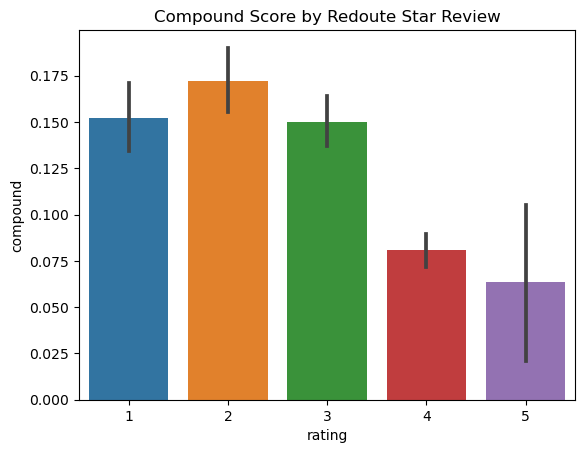

In [22]:
# Plot VADER results
ax = sns.barplot(data=vaders, x='rating', y='compound')
ax.set_title('Compound Score by Redoute Star Review')
plt.show();

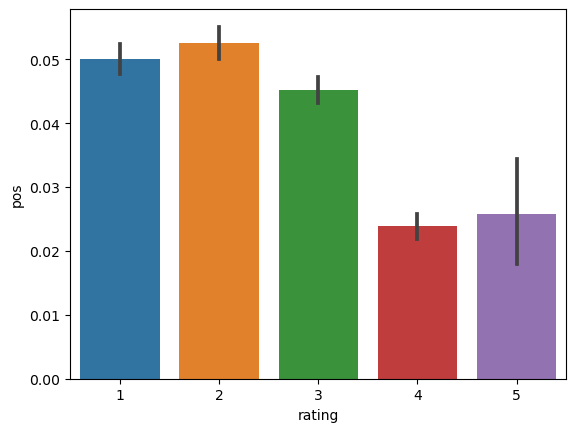

In [23]:
sns.barplot(data=vaders, x='rating', y='pos')
ax.set_title('Pos Score by Redoute Star Review')
plt.show();

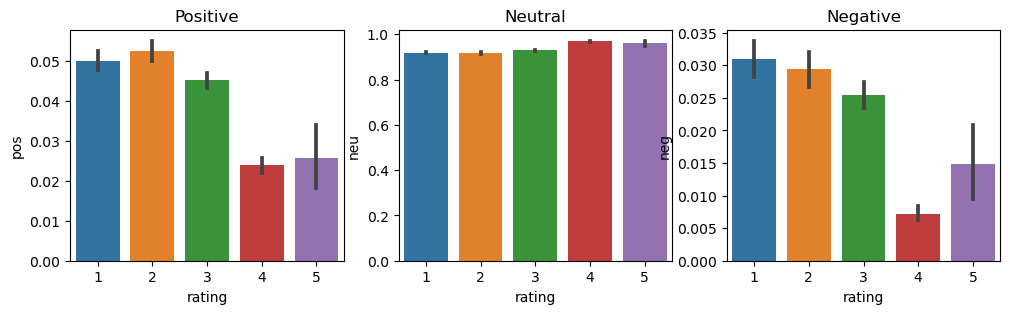

In [24]:
fig, axs = plt.subplots(1,3, figsize=(12,3))
sns.barplot(data=vaders, x='rating', y='pos', ax = axs[0])
sns.barplot(data=vaders, x='rating', y='neu', ax = axs[1])
sns.barplot(data=vaders, x='rating', y='neg', ax = axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.show()

## MODELISATION/APPROCHE TEXT MINING RoBERTa Model

In [ ]:
# Utilisation d'un modele entraine avec un large corpus de donnees
# Le modèle du transformateur prend en compte les mots 
# mais aussi le contexte lié à d'autres mots.

In [ ]:
!pip install transformers -U
!pip install tokenizers==0.13.0
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [ ]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [ ]:
# Resultats VADER  sur un  exemple
exemple = df['SupplierReply'][50]
print(exemple)
sia.polarity_scores(example)

In [ ]:
# Instanciation du modele Roberta

encoded_text = tokenizer(exemple, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

In [ ]:
# Definition d'une fonction pour parcourir le DataFrame

def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [ ]:
# Boucle sur le DataFrame avec try/except si trop de tokens

res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['SupplierReply']
        myid = row['id']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

## Comparaison des scores entre les 2 modeles

In [ ]:
# Affichage colonnes
results_df.columns

In [ ]:
# Combinaison et comparaison

In [ ]:
sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='Score',
            palette='tab10')
plt.show()

## Comparaison et observation de rating et sentiment

In [ ]:
results_df.query('Score == 1') \
    .sort_values('roberta_pos', ascending=False)['Text'].values[0]

In [ ]:
results_df.query('Score == 1') \
    .sort_values('vader_pos', ascending=False)['Text'].values[0]

In [ ]:
# Sentiment negatif avec un rating de 5 etoiles 

In [ ]:
results_df.query('Score == 5') \
    .sort_values('roberta_neg', ascending=False)['Text'].values[0]

In [ ]:
results_df.query('Score == 5') \
    .sort_values('vader_neg', ascending=False)['Text'].values[0]

## Creation d'un pipeline "Transformers"

In [ ]:
from transformers import pipeline

sent_pipeline = pipeline("sentiment-analysis")

In [ ]:
sent_pipeline('Merci pour votre commentaire!')

In [ ]:
sent_pipeline('Nous allons tenir compte de votre commentaire et tacher de trouver une solution')